# Time Series Analysis for Automated Machine Failure Detection

### Problem Statement

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


# Lets dive in!
Before we get started with the code below, there are few things to note for proper understanding of the code and its execution.
- A new file is created where all the utility functions are written. It is `utilities.py`
- In various plots, the X-axis is labelled as numbers instead of dates. This is for the convinence to read the graphs.
- Please make sure the `utilities.py` is in the same folder as this notebook.

That's all for now. Keep an eye on the small notes before the code chunks and graphs to better understand the information.

First lets dicsuss the steps that we will be going through.

####  `Loading the dataset and other important functions`

- Get all the resources into the notebook and load the dataset.

#### `Exploratory Data Analysis`

- Study the data carefully and see if we can find something interesting which can be used to solve the problem.

#### `Data Cleaning`

- Look for any observations that could affect the result of our analysis. Fix errors and noise in the data.

#### ` Data Modelling`

- Try two different approaches to see if they fit our data and achieve the goal.


#### `Performance`

- See how well these model perform on all machine readings.

#### `Limitations`

- What are limitations of these approaches and which model could be used to better reach out goal.


*Now that we have an overview of what we will be doing, lets start with the process.*


# Load Data and other important functions

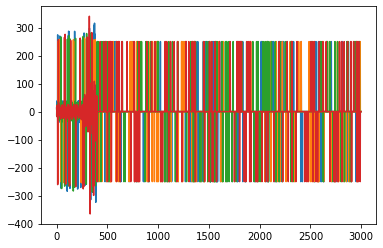

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
%matplotlib inline 
#import statsmodels.api
data = pd.read_csv('exampleco_data/machine_0.csv',index_col=0)

plt.plot(range(len(data)), data)
plt.show()

# Exploratory Data Analysis

It is always better to see few observations in the dataset. We will consider one machine at this time. Once we have developed a stratergy to achieve the goal for this machine, we can test the results for others.

In this part, we will get an overview of data and also perform data cleaning if required.

First, lets see what the data looks like and what the readings are about.

In [2]:
#Print top few rows of the data
data.head(10)

,0,1,2,3
2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561
2019-01-02 16:00:48.016005335,29.646637,-3.522426,3.364964,-3.015832
2019-01-03 00:00:57.619206402,38.902674,1.916522,-10.849385,-17.702242
2019-01-03 08:01:07.222407469,33.052626,3.204629,25.474912,1.118645
2019-01-03 16:01:16.825608536,25.190551,-5.460431,22.956234,-3.472719
2019-01-04 00:01:26.428809603,29.554267,-3.325767,-5.842399,-25.124870


In [3]:
data.describe()

,0,1,2,3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


There are 4 varialbes for each machine and the values have a wide range with mean and median close to zero. This is probably because after the machine failure, readings are close to zero which bring down the mean and median values.

Lets get the clear picture by looking at the distribution of values by plotting a histogram and scatterplot.
### Histogram

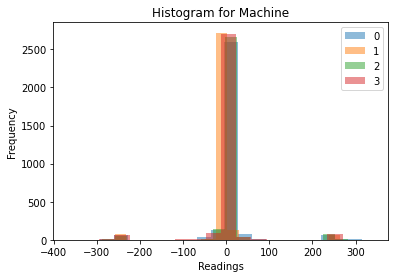

In [4]:
show_histogram(data)

### Scatterplot
We draw scatterplot with time on X-axis and readings on Y-axis. Note that the timestamps are not mentioned. Instead we use the order in which the readings are taken.

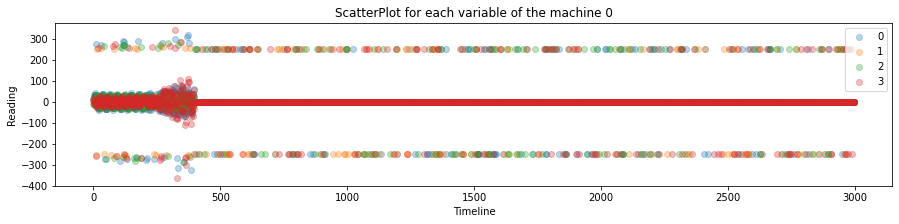

In [5]:
scatter(data)

From the graphs above, we can see that the outliers lie beyound 100 and -100. Lets get rid of the outliers and see the distribution of data again. To fix the outlier problem, we would replace them with any other statistic like mean, median, mode or impute the values as well. We will replace them using median for this problem. The outliers are those which are 2 standard deviations away from the mean.

These outliers are actually the moderate noise that is recorded due to communication error. It is better to get rid of the noise to perform analysis better.

## Data Cleaning

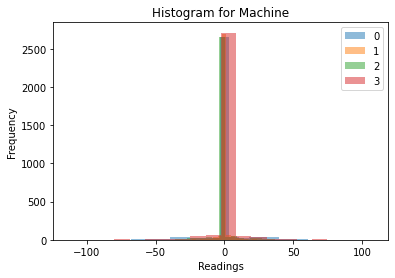

In [6]:
df = replace_with_median(data.copy())
show_histogram(df)

Lets take a look at the scatterplot of the cleaned data now.

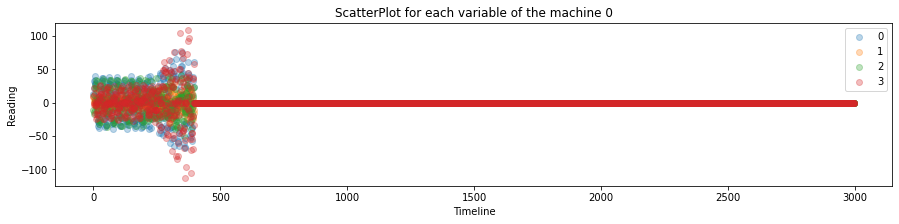

In [7]:
scatter(df)

In this scatterplot, we can see that before the system fails, there is some increase in the reading fluctuations than normal. This is the faulty area and we need to build a model to identify this.

So to conclude the exploratory data analysis part following are the points that we found.

- Each machine takes 4 different readings and we classify it as `failed` when these readings are close to zero.
- There are few outliers in the data which is the noise while taking the readings.
- We handled the noise by removing it and then see the scatterplot again. 
- From this plot it is clear that there are three phases of the machine operation.

#### Normal: When the readings flucutates in a specific range
#### Faulty: When we see some anomalies in the readings as they exceed the normal range.
#### Failure: When the readings are close to zero.

## Classify the readings into three different categories.
Now the next goal is to find when the machine is in `normal, faulty` and `failure` state. The main target is to find when the machine transitions from `normal` to `faulty` state. To do so, we will use two statistical approaches. 

- Chauvenet’s Criterion
- Rolling Statistic Approach

### Chauvenet’s Criterion

Chauvenet’s criterion is probably the most straight forward, once we have a normal distribution we can flag outliers in any sample separated a number of deviations from the average value. To implement this, we start by considering first 30 readings of the machine. We calcualte mean and standard deviation of the variables. Then using these values, we create confidence bands 2 standard deviations away from the mean. This helps us get the normal range in which the data fluctuates. The points outside this band are rare and could be considered as anomaly. If more than 3 anomalies occur, we alert the owner that the machine has entered in faulty state and needs attention.

The function `Chauvenet` implements this approach. The following figure shows the output where it shows the point of transition from normal into faulty region and from faulty to failure region

### Rolling Statistic Approach

We now know that the readings for each variable fluctuate in a defined constraint before transitioning from normal to faulty state. We will use rolling statistics to keep track of behaviour of the readings and detect anomalies. When we find anomaly, it is a sign that the readings are not normal and something weird is happening. We need to alert the machine owner that the machine performance is not normal and it is in faulty state, so needs a repair. If not done, it will fail.

In this approach , we calcualte two different things
- Rolling Mean
- Rolling Standard Deviation.

Rolling Mean helps us to find the expected value of the reading and rolling standard deviation helps us map the expected errors. If the reading in at some point exceeds this expected error range, we classify it as anomaly. We do this for each variable of the machine and keep track of the anomalies occuring. If more than 2 anomalies occur, we alert the owner that the machine has entered in faulty state and needs attention.

The function `rolling_statistic_detection` implements this approach. 

- The following figures shows the output where it shows the point of transition from `normal` into `faulty` region and from `faulty` to `failure` region

We have defined a function which detects the faulty region using both approaches. Passing the functions a `method` paramter will give the results for each approach. The function for this is `define_fault_region` 


### Chauvenet’s Criterion


Machine 0 entered faulty state at 2019-03-29 16:42:05.641880627
Time to failure was 45 days 08:21:46.035345


Timedelta('45 days 08:21:46.035345')

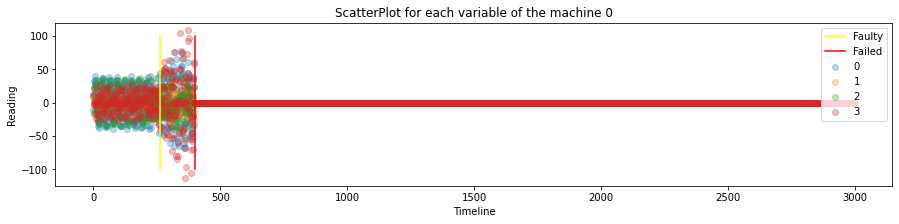

In [8]:
define_fault_region(df,method=Chauvenet)

You can see that the we are successfully able to find the transition of machine from normal to faulty state(Yellow vertical Line). We made aware about the problem and raised alert on `2019-03-29 16:42:05.641880627`. From that point, the machine after 45 days. (Failure is red vertical line) 

### Time to Failure
We define this 45 days as `TTF(Time to Failure)`. It means that we raised alert 45 days prior. The TTF could be unique for each machine. It is the differnce between the time when machine transitions from normal to faulty state and faulty to failure state.


Now lets try doing the same with different approach.

### Rolling Statistic Approach


Machine 0 entered faulty state at 2019-03-29 16:42:05.641880627
Time to failure was 45 days 08:21:46.035345


Timedelta('45 days 08:21:46.035345')

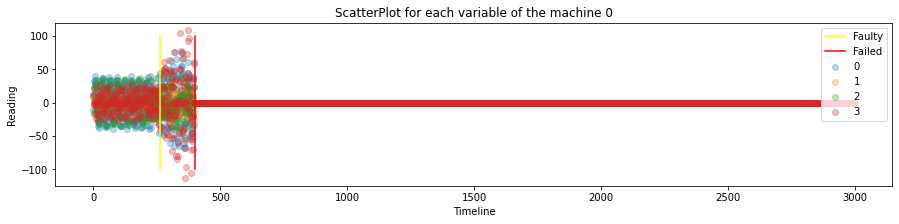

In [9]:
define_fault_region(df,method=rolling_statistic_detection)

The results are quite similar for this approach as well. TTF is around 45 days. 

Now that we are able to do this for this machine, lets see how it performs on all other machines.

## Results for all Machines
Lets see how these approaches work for all other machines. Following are the results of both approaches for each machine respectively.

## Chauvenet’s Criterion


Machine 0 entered faulty state at 2019-03-29 16:42:05.641880627
Time to failure was 45 days 08:21:46.035345

Machine 1 entered faulty state at 2020-06-16 04:15:26.708902968
Time to failure was 48 days 00:23:02.860953

Machine 2 entered faulty state at 2019-12-31 02:54:46.695565188
Time to failure was 263 days 10:06:26.528842

Machine 3 entered faulty state at 2021-09-27 00:00:00.000000000
Time to failure was -963 days +16:18:05.161720

Machine 4 entered faulty state at 2019-01-16 16:07:31.350450150
Time to failure was 6 days 00:02:52.857619

Machine 5 entered faulty state at 2019-03-18 00:36:29.529843281
Time to failure was 57 days 00:27:22.147382

Machine 6 entered faulty state at 2019-05-30 17:11:51.837279094
Time to failure was 59 days 00:28:19.766588

Machine 7 entered faulty state at 2020-03-08 11:27:35.351783928
Time to failure was 57 days 00:27:22.147382

Machine 8 entered faulty state at 2019-07-13 01:32:40.253417806
Time to failure was 105 days 16:50:44.214738

Machine 9 ente

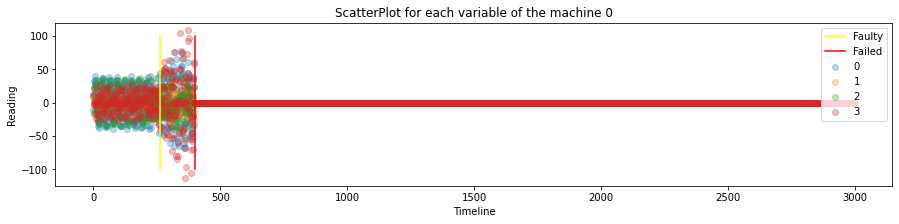

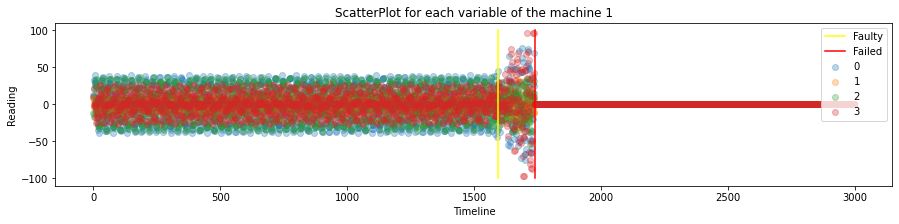

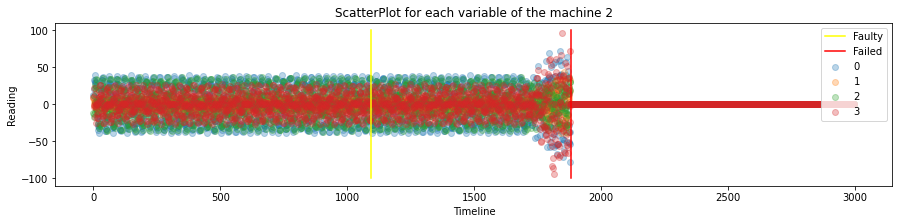

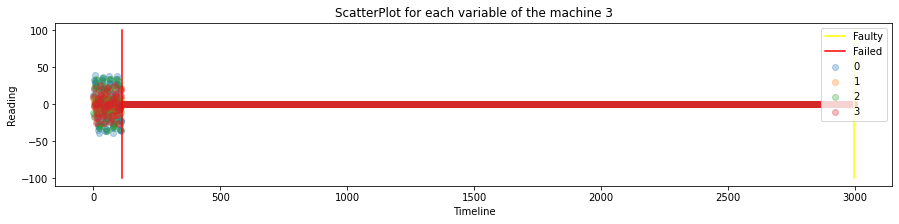

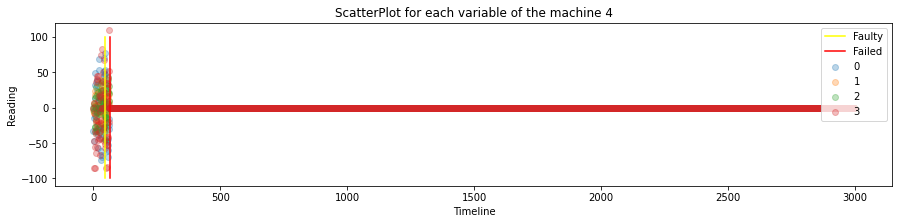

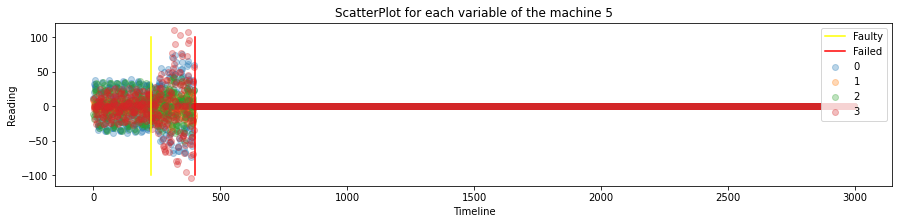

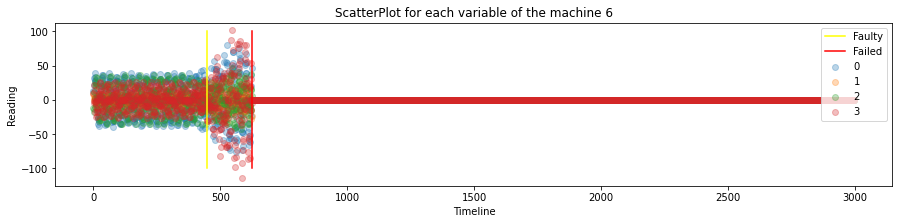

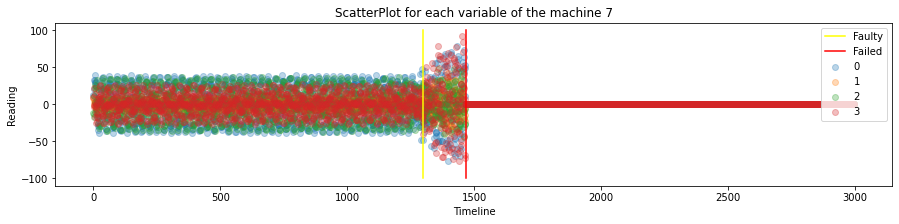

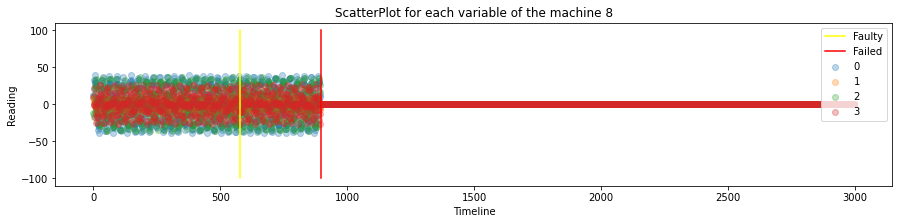

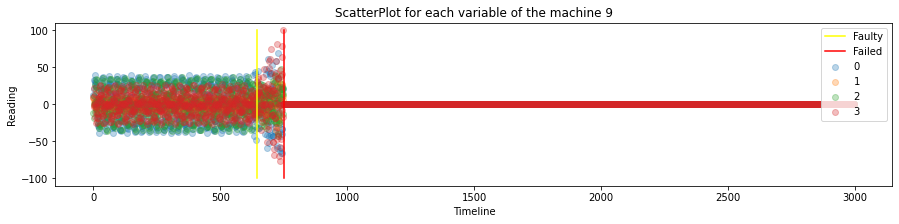

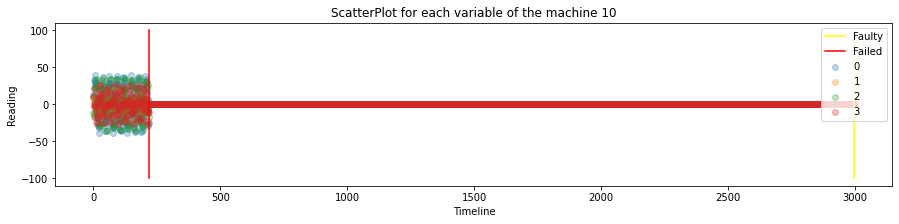

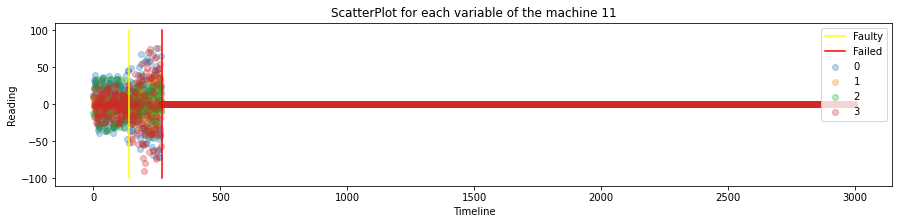

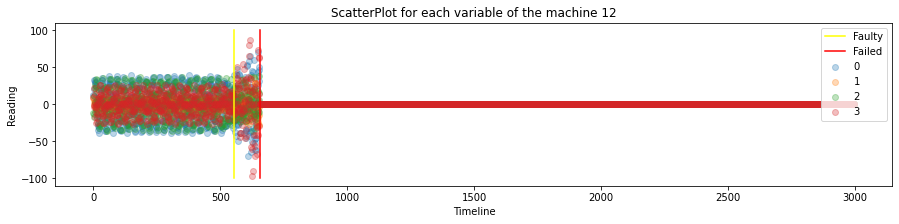

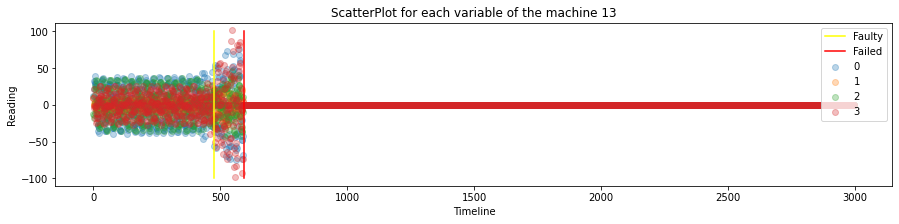

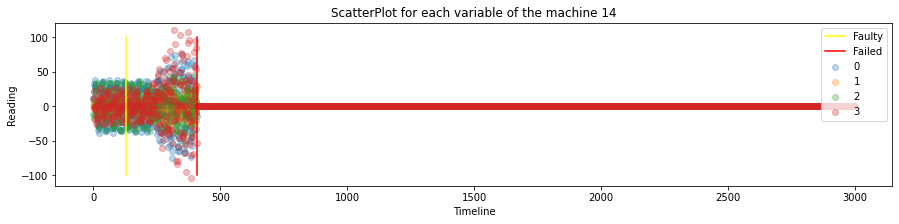

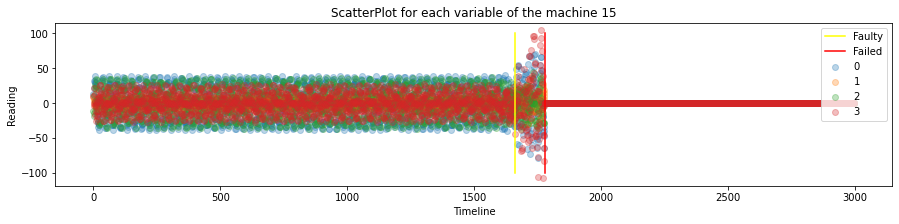

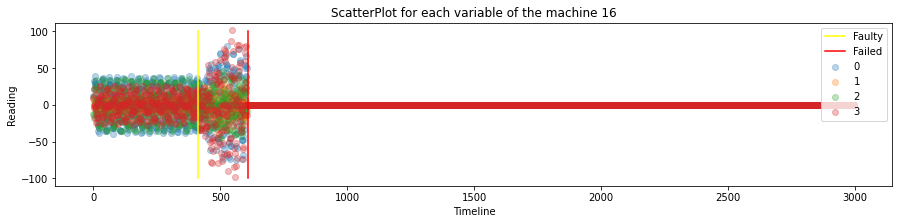

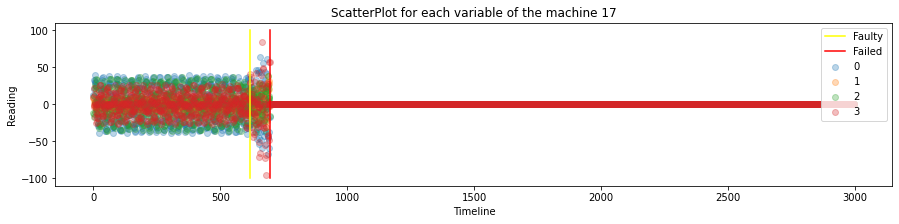

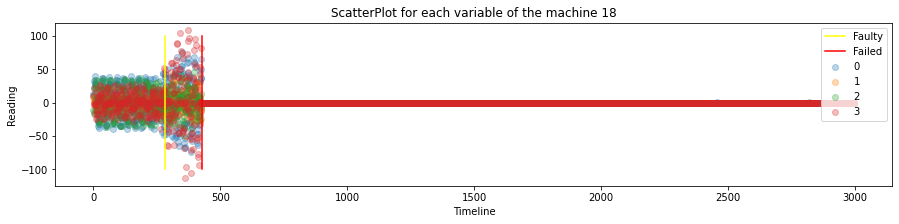

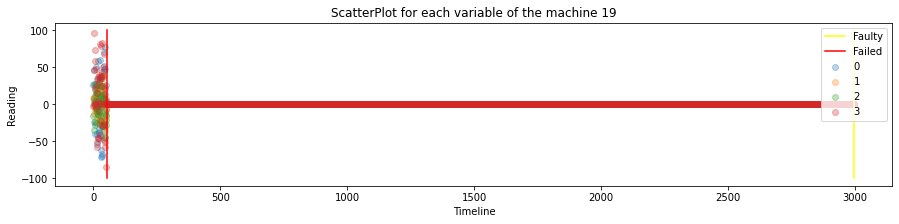

In [10]:
TTF_c = []
for i in range(20):
    path = ('exampleco_data/machine_{}.csv'.format(i))
    data = pd.read_csv(path,index_col=0)
    df = replace_with_median(data.copy())
    TTF_c.append(define_fault_region(df,method=Chauvenet,machine_no = i))

## Average Time to Failure
We have also calculated the average time has is passed after the system enters faulty state and transitions to failure state. This time difference is the Time to Failure(TTF). 

Using TTF for each machine, we can find average TTF. By looking at this value, we can see find that what is the average time that elapses before the machine fails (considering that we know the time at which machine enters into faulty state). 

As you can see, our model fails to detect faulty stats for some machines and the machine fails. We ignore those values while calculating average TTF as those are negative.

`average_TTF` implements the steps to calculate average time to failure as shown below.

In [11]:
average_TTF(TTF_c)


Average Time to failure considering all the machines is 62.705882352941174 days


## Rolling Statistic Approach


Machine 0 entered faulty state at 2019-03-29 16:42:05.641880627
Time to failure was 45 days 08:21:46.035345

Machine 1 entered faulty state at 2020-06-28 12:21:22.027342448
Time to failure was 35 days 16:17:07.542514

Machine 2 entered faulty state at 2020-08-05 20:39:46.395465160
Time to failure was 44 days 16:21:26.828942

Machine 3 entered faulty state at 2019-03-04 16:30:05.401800600
Time to failure was -26 days +23:47:59.759919

Machine 4 entered faulty state at 2019-02-08 08:18:24.368122707
Time to failure was -17 days +07:51:59.839946

Machine 5 entered faulty state at 2019-03-28 00:41:17.625875292
Time to failure was 47 days 00:22:34.051350

Machine 6 entered faulty state at 2019-05-30 09:11:42.234078026
Time to failure was 59 days 08:28:29.369789

Machine 7 entered faulty state at 2020-03-06 19:26:47.335778592
Time to failure was 58 days 16:28:10.163387

Machine 8 entered faulty state at 2019-11-19 10:34:46.295431812
Time to failure was -24 days +07:48:38.172724

Machine 9 en

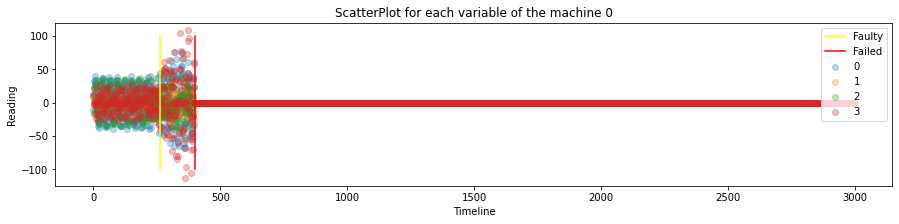

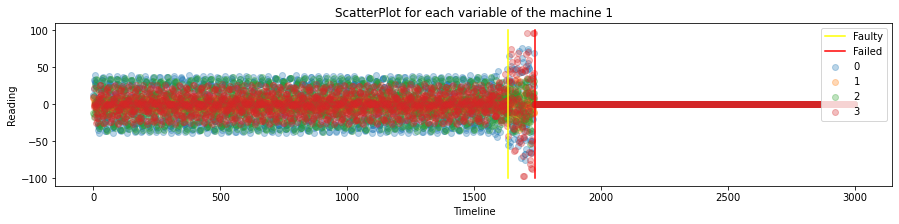

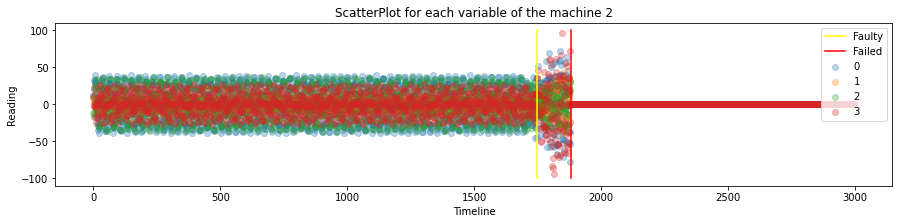

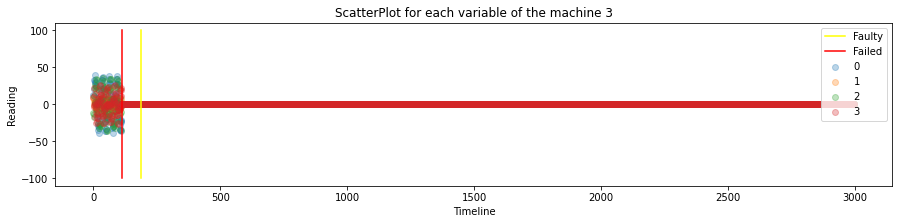

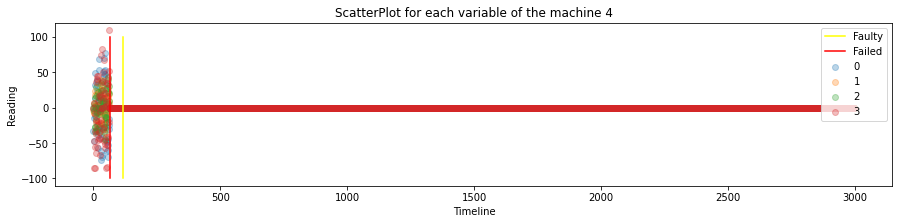

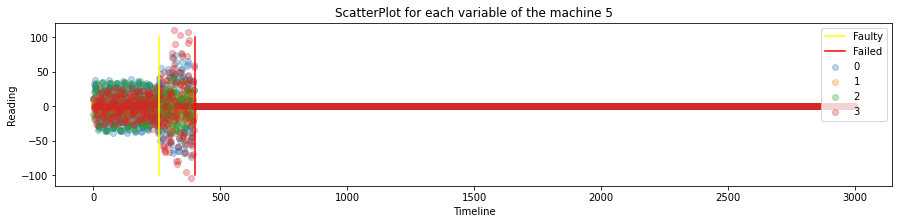

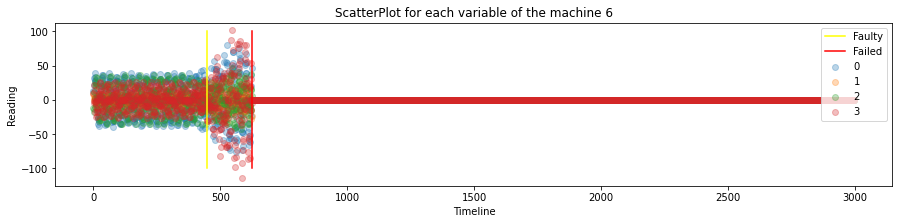

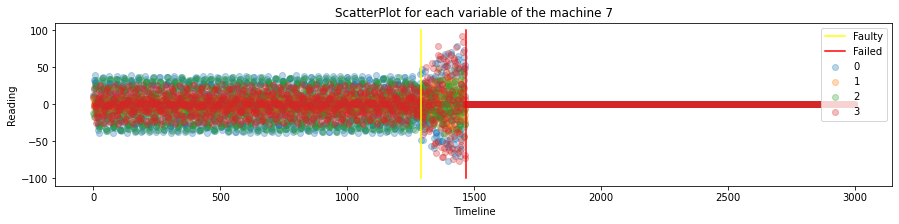

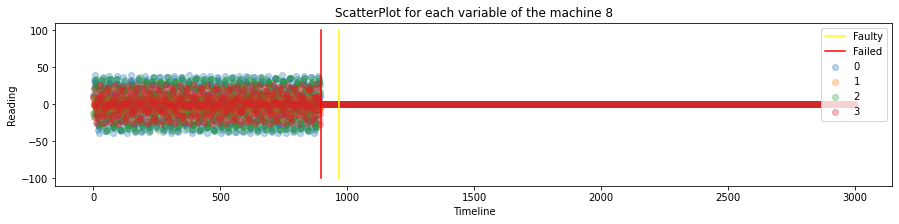

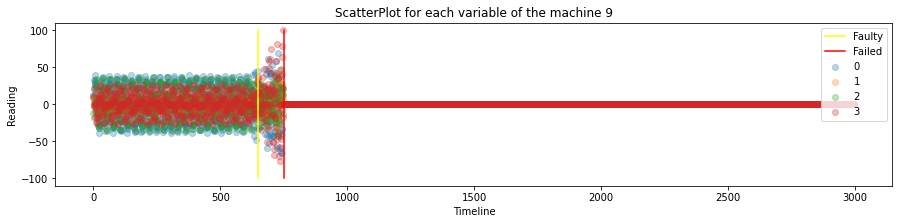

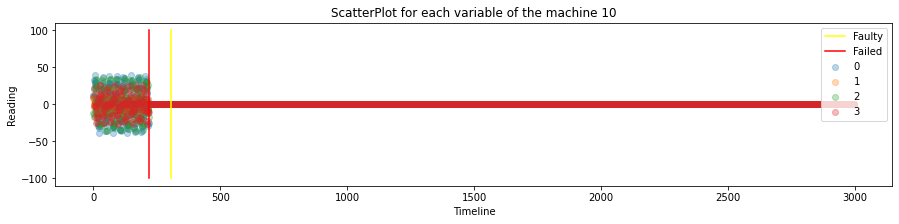

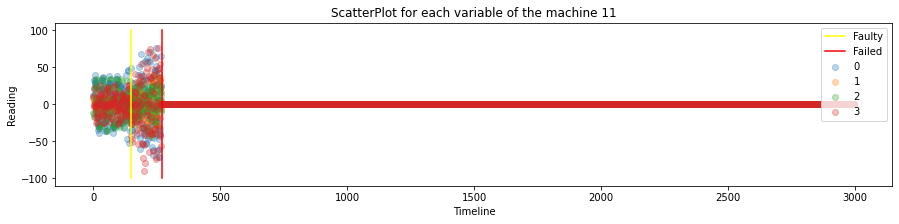

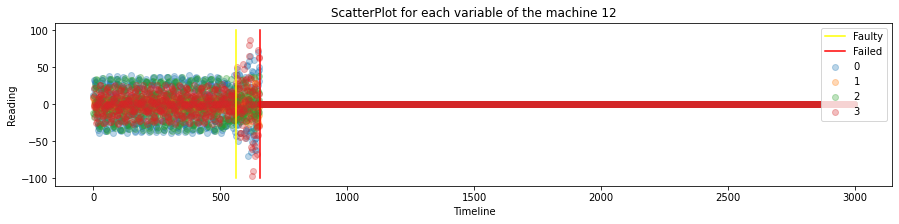

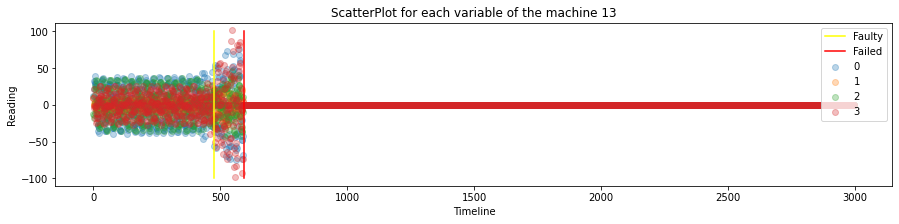

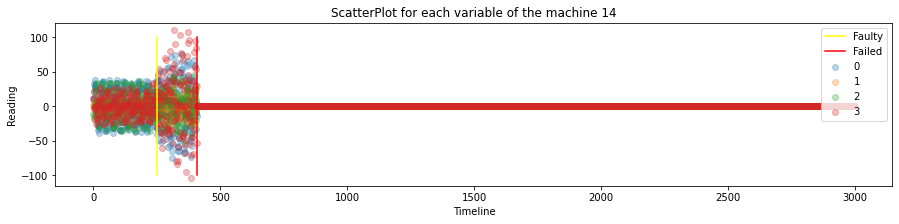

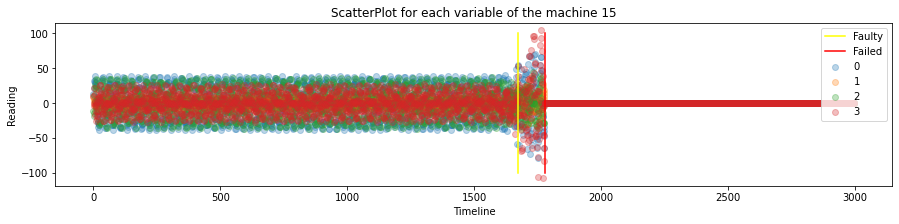

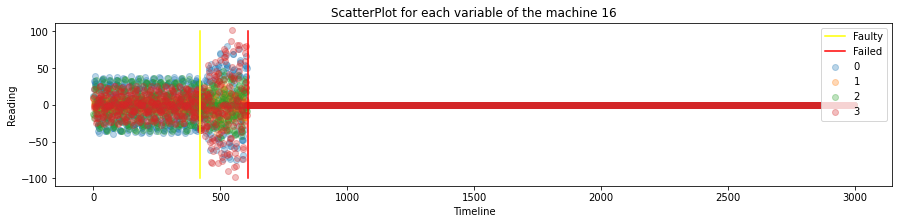

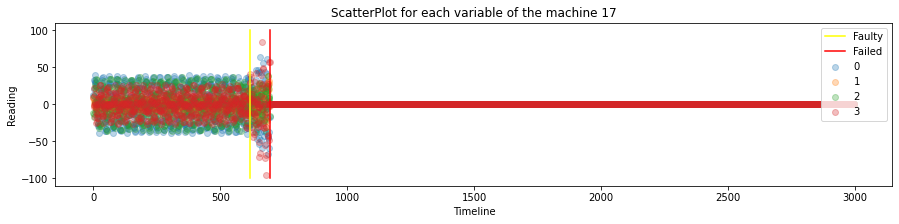

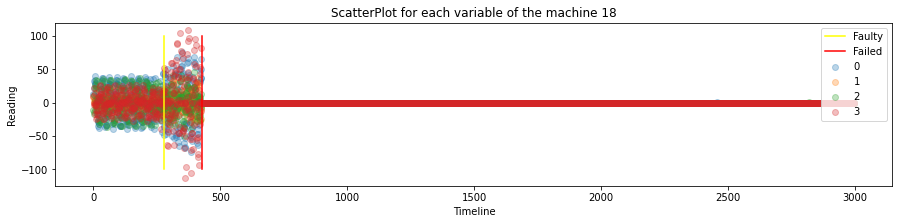

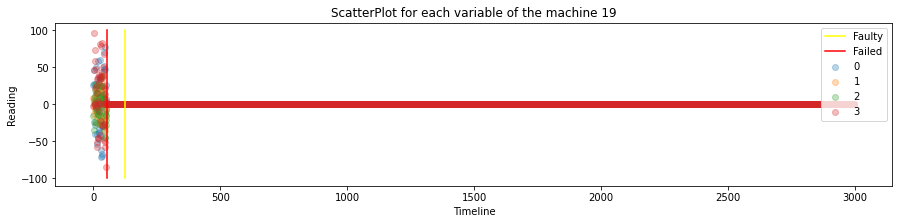

In [12]:
TTF_r = []
for i in range(20):
    path = ('exampleco_data/machine_{}.csv'.format(i))
    data = pd.read_csv(path,index_col=0)
    df = replace_with_median(data.copy())
    TTF_r.append(define_fault_region(df,method=rolling_statistic_detection,machine_no = i))

## Average Time to Failure

In [13]:
average_TTF(TTF_r)


Average Time to failure considering all the machines is 43.93333333333333 days


## How good are these approaches performing?
Now that we see there are few times where we are not able to perform well, lets see how good the predictions are.

We can see there are few machines which do not perform as we expect before failure. They keep going in normal state and directly fail. In this case, our approach won't work. So the TTF is negative. This is where our model fails. We now calculate the number of times our models perform well.

The readings of TTF for each approach is stored in list TTF_c and TTF_r.  We find the number of times we were able to find transition from normal to faulty state using these lists.

`performance` functions gives us the required results by passing the list of TTF for each approach.

### Performance of Chauvenet’s Criterion approach

In [14]:
performance(TTF_c)


We were able to find faulty transition in 17 machines
Model performance is 0.85


### Performance of Rolling Statistics approach

In [15]:
performance(TTF_r)


We were able to find faulty transition in 15 machines
Model performance is 0.75


Looking at the performance measure, `Chauvenet's` approach works good for most of the machines than rolling statistic. The model accurately finds the faulty state transition *85%* of the times. The predictions are good as we know that the machine is going to fail prior to 62 days on average, with atleast 6-27 days. This time frame could be considered enough to make the repairs that are needed, hence saving a lot of money for the machine owner.
Both of the approaches are simple and easy to understand, but yet very powerful and perform well.
Following are the performance points of each approach

#### Chauvenet's
- Identifies transition from normal to faulty state for `17` machines
- Performanace measure is `0.85`
- The average Time to failure is `62` days with range [6-263]

#### Rolling Statistics Apporach
- Identifies transition from normal to faulty state for `15` machines
- Performanace measure is `0.75`
- The average Time to failure is `43` days with range [27-63]

### Limitations
As we can see that there are a lot of good points about the both the approaches, we can spot few limtations as well. 

- Chauvenet's approach is able to identify the fault regions in more machines than Rolling Statistics, the range of TTF for Chauvenet's is wide than that of other approach. So it is upto the user which approach to use depending upon the prefrence. 

- If accuracy is of utmost importance, the first method is a goto. If more than 25 days are needed for the repair, owner would be suggested to prefer second method.

- Both approaches could not pick the faulty state transition for the readings which stay in the normal region It is difficult for these models to identify such readings. 

- A neural networks approach could be used to get these reading correct. Now that we have classified the regions correctly for 15 machines, we can label them and convert the problem to supervised learning, train the model using neural networks and then test it for the machines that our models fail to classify. 

